In [1]:
import copy

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from rdkit import Chem
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool

In [2]:
class GCNMoleculeModel(nn.Module):
    def __init__(self, num_node_features):
        super(GCNMoleculeModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GATConv(128, 128, heads=4, concat=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, edge_index, batch=None):
        # 単一グラフなどで batch=None の場合、すべてのノードを1つのグラフとみなす
        if batch is None:
            # 全ノードが graph=0 に属する、という扱い
            batch = x.new_zeros(x.size(0), dtype=torch.long)

        # 1) グラフ畳み込み
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x, edge_index)))

        # 2) グローバルプーリング (バッチ単位)
        x = global_mean_pool(x, batch)

        # 3) 全結合層で回帰
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x.view(-1)

In [3]:
class MoleculeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        smiles_list = df["smiles"].values
        values = df["logS"].values
        data_list = [
            (self.smiles_to_graph(smiles), torch.tensor([label], dtype=torch.float))
            for smiles, label in zip(smiles_list, values)
        ]
        self.data_list = data_list

    @staticmethod
    def smiles_to_graph(smiles):
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)

        node_features = []
        for atom in mol.GetAtoms():
            feature = [
                atom.GetAtomicNum(),
                atom.GetTotalDegree(),
                atom.GetFormalCharge(),
                atom.GetTotalNumHs(),
                int(atom.GetIsAromatic()),
            ]
            node_features.append(feature)

        edges = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edges.append([i, j])
            edges.append([j, i])

        x = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        return Data(x=x, edge_index=edge_index)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

In [4]:
dataset = MoleculeDataset(csv_path="../data/delaney-rdkitfp.csv")

In [5]:
test_size = 0.2
val_size = 0.2
train_val_data, test_data = train_test_split(dataset, test_size=test_size)
train_data, val_data = train_test_split(
    train_val_data, test_size=val_size / (1 - test_size)
)

In [6]:
batch_size = 8
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

loaders = {"train": train_loader, "val": val_loader, "test": test_loader}

/home/mori/miniforge3/envs/torch/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.mse_loss(output, target.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [8]:
def evaluate(model, loader, device):
    model.eval()
    predictions = []
    targets = []
    total_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = F.mse_loss(out, target.squeeze())
            total_loss += loss.item() * data.num_graphs
            predictions.append(out.cpu())
            targets.append(target.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()
    avg_loss = total_loss / len(loader.dataset)
    return predictions, targets, avg_loss

In [9]:
model = GCNMoleculeModel(num_node_features=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
# Early stoppingの設定
best_val_loss = float("inf")
patience = 10
counter = 0
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loss_history = []
val_loss_history = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, device)
    _, _, val_loss = evaluate(model, val_loader, device)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(
        f"Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

# model.load_state_dict(torch.load('best_model.pth'))
_, _, test_loss = evaluate(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")

Epoch: 001, Train Loss: 5.7006, Val Loss: 3.0410
Epoch: 002, Train Loss: 3.5334, Val Loss: 2.1649
Epoch: 003, Train Loss: 3.1230, Val Loss: 2.1304
Epoch: 004, Train Loss: 2.8303, Val Loss: 1.8058
Epoch: 005, Train Loss: 2.7299, Val Loss: 1.8114
Epoch: 006, Train Loss: 2.3575, Val Loss: 1.7484
Epoch: 007, Train Loss: 2.4548, Val Loss: 1.7411
Epoch: 008, Train Loss: 2.3121, Val Loss: 1.4925
Epoch: 009, Train Loss: 2.2961, Val Loss: 1.6830
Epoch: 010, Train Loss: 2.3796, Val Loss: 1.4072
Epoch: 011, Train Loss: 2.2929, Val Loss: 1.6136
Epoch: 012, Train Loss: 2.2589, Val Loss: 1.5208
Epoch: 013, Train Loss: 2.1087, Val Loss: 1.4539
Epoch: 014, Train Loss: 2.0853, Val Loss: 1.2907
Epoch: 015, Train Loss: 2.0081, Val Loss: 1.3279
Epoch: 016, Train Loss: 2.1174, Val Loss: 1.6316
Epoch: 017, Train Loss: 2.1104, Val Loss: 1.7265
Epoch: 018, Train Loss: 2.1418, Val Loss: 1.5640
Epoch: 019, Train Loss: 1.9387, Val Loss: 1.2755
Epoch: 020, Train Loss: 2.1376, Val Loss: 1.6055
Epoch: 021, Train Lo

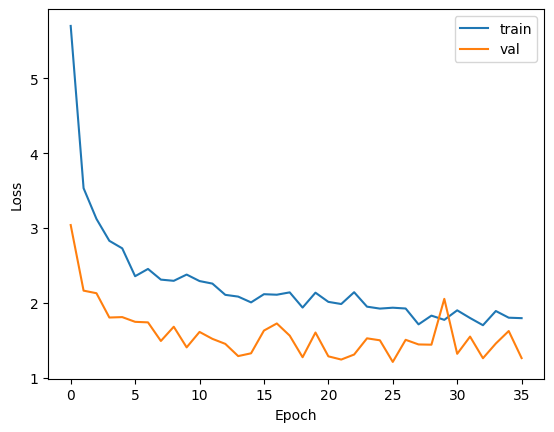

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_loss_history, label="train")
ax.plot(val_loss_history, label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
# ax.set_yscale("log")

Text(0, 0.5, 'logS (predict)')

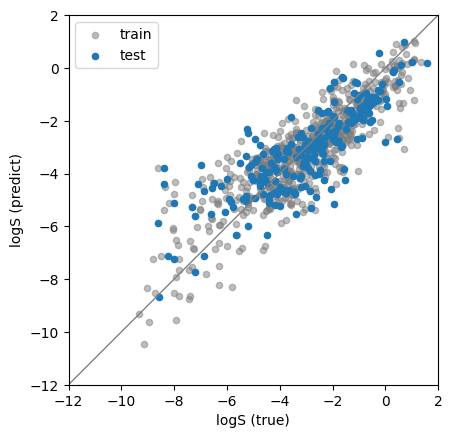

In [12]:
train_preds, train_targets, _ = evaluate(model, train_loader, device)
test_preds, test_targets, _ = evaluate(model, test_loader, device)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_targets, train_preds, color="tab:gray", alpha=0.5, label="train", s=20)
ax.scatter(test_targets, test_preds, color="tab:blue", label="test", s=20)
ax.plot([-12, 2], [-12, 2], color="gray", linewidth=1)
ax.set_xlim(-12, 2)
ax.set_ylim(-12, 2)
ax.set_aspect("equal")
ax.legend()
ax.set_xlabel("logS (true)")
ax.set_ylabel("logS (predict)")

In [13]:
def remove_edge_by_index(data: Data, edge_idx: int):
    data_perturbed = copy.deepcopy(data)
    mask = torch.ones(data.edge_index.size(1), dtype=torch.bool)
    mask[edge_idx] = False
    data_perturbed.edge_index = data.edge_index[:, mask]
    if hasattr(data_perturbed, "edge_attr") and data_perturbed.edge_attr is not None:
        data_perturbed.edge_attr = data_perturbed.edge_attr[mask]

    return data_perturbed

In [14]:
from typing import Dict

from torch_geometric.data import Data


def calc_contrib_perturb(
    smiles: str, model: torch.nn.Module, device: str = "cpu"
) -> Dict[str, Dict[int, float]]:
    model.eval()

    # ======== 1) SMILES から PyG の Data を作成 ========
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Cannot parse SMILES: {smiles}")
    mol = Chem.AddHs(mol)

    data = MoleculeDataset.smiles_to_graph(smiles)
    data = data.to(device)

    # ======== 2) 基準予測値 (base_pred) を計算 ========
    with torch.no_grad():
        base_out = model(data.x, data.edge_index, data.batch)
        base_pred = base_out.item()

    # ======== 3) ノード摂動の寄与度を計算 ========
    node_contributions = {}
    num_nodes = data.x.size(0)
    for node_idx in range(num_nodes):
        data_perturbed = copy.deepcopy(data)
        # 該当ノードの特徴量を 0 に
        data_perturbed.x[node_idx, :] = 0.0

        with torch.no_grad():
            pert_out = model(
                data_perturbed.x, data_perturbed.edge_index, data_perturbed.batch
            )
            pert_pred = pert_out.item()

        delta_pred = base_pred - pert_pred
        node_contributions[node_idx] = delta_pred

    # ======== 4) エッジ摂動の寄与度を計算 (同一ボンドはまとめる) ========
    edge_contributions = {}
    num_edges = data.edge_index.size(1)

    for edge_idx in range(num_edges):
        data_perturbed = remove_edge_by_index(data, edge_idx)

        with torch.no_grad():
            pert_out = model(
                data_perturbed.x, data_perturbed.edge_index, data_perturbed.batch
            )
            pert_pred = pert_out.item()

        delta_pred = base_pred - pert_pred

        nodes_for_this_edge = data.edge_index[:, edge_idx].tolist()
        nodes_for_this_edge = sorted(set(nodes_for_this_edge))
        if len(nodes_for_this_edge) < 2:
            continue

        a, b = nodes_for_this_edge[0], nodes_for_this_edge[1]
        bond = mol.GetBondBetweenAtoms(int(a), int(b))
        if bond is None:
            continue

        bond_id = bond.GetIdx()
        if bond_id in edge_contributions:
            edge_contributions[bond_id] += delta_pred
        else:
            edge_contributions[bond_id] = delta_pred

    return {"nodes": node_contributions, "edges": edge_contributions}

In [15]:
# 予測値寄与度の計算
smiles = "CCO"  # エタノールなど
contribs = calc_contrib_perturb(smiles, model, device)

print("Node Contributions:", contribs["nodes"])
print("Edge Contributions:", contribs["edges"])

Node Contributions: {0: -0.08411797881126404, 1: -0.07190418243408203, 2: 1.6586908400058746, 3: 0.007530808448791504, 4: 0.0075307488441467285, 5: 0.007530778646469116, 6: -0.05390915274620056, 7: -0.05390918254852295, 8: 0.031625837087631226}
Edge Contributions: {0: 0.07038426399230957, 1: 0.544378250837326, 2: 0.12293446063995361, 3: 0.12293446063995361, 4: 0.12293440103530884, 5: 0.3347828909754753, 6: 0.3347828909754753, 7: 3.2428138852119446}


In [16]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import SVG, display
from rdkit.Chem.Draw import rdMolDraw2D


def visualize_contributions(
    smi, model, cmap="bwr_r", alpha=0.9, vmin=-5, vmax=5, size=(250, 250)
):
    contribs = calc_contrib_perturb(smi, model, device)
    cmap = cm.get_cmap(cmap)
    atom_colors = {}

    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for i, val in contribs["nodes"].items():
        rgba = list(cmap(norm(val)))
        rgba[3] = alpha
        atom_colors[i] = tuple(rgba)

    bond_colors = {}
    for i, val in contribs["edges"].items():
        rgba = list(cmap(norm(val)))
        rgba[3] = alpha
        bond_colors[i] = tuple(rgba)

    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(*size)

    rdMolDraw2D.PrepareAndDrawMolecule(
        drawer,
        mol,
        highlightAtoms=list(atom_colors.keys()),
        highlightAtomColors=atom_colors,
        highlightBonds=list(bond_colors.keys()),
        highlightBondColors=bond_colors,
    )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace("svg:", "")
    display(SVG(svg))

/tmp/ipykernel_27836/805251432.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


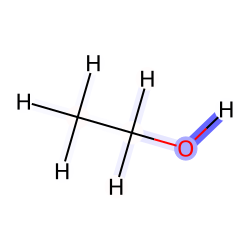

In [17]:
visualize_contributions("CCO", model)

In [18]:
def calc_contrib_gradient(
    smiles: str, model: torch.nn.Module, device: str = "cpu"
) -> Dict[str, torch.Tensor]:
    model.eval()

    # (1) SMILES から分子を作り、PyG Data へ
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Cannot parse SMILES: {smiles}")
    mol = Chem.AddHs(mol)

    data = MoleculeDataset.smiles_to_graph(
        smiles
    )  # 例: ユーザ定義の Dataset クラスのメソッド
    data = data.to(device)

    # (2) x (ノード特徴量) に対して勾配を計算できるように requires_grad=True
    data.x.requires_grad = True

    # (3) 順伝搬でスカラー出力 (回帰タスクを想定)
    out = model(data.x, data.edge_index, data.batch)
    # 複数次元の場合は何らかの形でスカラーに集約
    if out.dim() > 0:
        out = out.mean()

    # (4) 逆伝搬
    out.backward()

    # (5) ノードの勾配を取得し、ノード単位の重要度を計算
    node_grads = data.x.grad.detach().clone()  # shape=(num_nodes, num_node_features)

    # node_importance = node_grads.mean(dim=-1)
    # node_importance = node_grads.sum(dim=-1)
    node_importance = (data.x * node_grads).sum(dim=-1).detach().clone().numpy()
    return {
        "nodes": {i: v for i, v in enumerate(node_importance)},  # (num_nodes,)
    }

In [19]:
smiles = "CCO"
contribs = calc_contrib_gradient(smiles, model, device)

print("Node Contributions:", contribs["nodes"])

Node Contributions: {0: 0.080037564, 1: -0.9250129, 2: -0.20440826, 3: 0.018801652, 4: 0.01880166, 5: 0.01880166, 6: -0.118904054, 7: -0.118904054, 8: -0.14860463}


In [20]:
def visualize_contributions(
    smi: str,
    model: torch.nn.Module,
    device: str = "cpu",
    cmap: str = "bwr_r",
    alpha: float = 0.9,
    vmin: float = -1,
    vmax: float = 1,
    size=(250, 250),
):
    contribs = calc_contrib_gradient(smi, model, device=device)

    cmap = cm.get_cmap(cmap)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    atom_colors = {}
    for i, val in contribs["nodes"].items():
        rgba = list(cmap(norm(val)))
        rgba[3] = alpha
        atom_colors[i] = tuple(rgba)

    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(*size)
    rdMolDraw2D.PrepareAndDrawMolecule(
        drawer,
        mol,
        highlightAtoms=list(atom_colors.keys()),
        highlightAtomColors=atom_colors,
    )
    drawer.FinishDrawing()

    svg = drawer.GetDrawingText().replace("svg:", "")
    display(SVG(svg))

/tmp/ipykernel_27836/3066708764.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


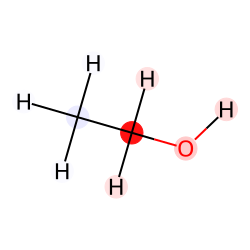

In [21]:
visualize_contributions("CCO", model)

In [22]:
from typing import Dict

import torch
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer


def calc_contrib_explainer(
    smiles: str,
    model: torch.nn.Module,
    device: str = "cpu",
    explainer_epochs: int = 200,
) -> Dict[str, Dict[int, float]]:
    model.eval()

    # 1) SMILES → RDKit Mol
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Cannot parse SMILES: {smiles}")
    mol = Chem.AddHs(mol)

    # 2) PyG Data を作成 (例: ユーザ定義 MoleculeDataset)
    data = MoleculeDataset.smiles_to_graph(smiles)
    data = data.to(device)

    # 3) Explainer を作成
    #    - algorithm=GNNExplainer(...) を指定
    #    - regression タスクの場合: mode='regression', task_level='graph', return_type='raw' (など)
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=explainer_epochs),
        explanation_type="model",  # モデル自身を説明
        node_mask_type="attributes",  # ノードの特徴をマスク対象に
        edge_mask_type="object",  # エッジ(オブジェクト)をマスク対象に
        model_config=dict(
            mode="regression",  # 回帰タスク
            task_level="graph",  # グラフ単位の説明
            return_type="raw",  # モデルの出力がそのままスカラー (生値) なら 'raw'
        ),
    )

    # 4) 実際に説明を実行
    #    単一グラフの場合、batchが無い・あるいはすべて0でもOK
    #    explainer(...) の結果は Explanation オブジェクト
    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        # data.edge_attr があれば edge_attr=...
    )

    # 5) ノードマスク, エッジマスクを取得
    #    shape: node_mask=[num_nodes, num_node_features], edge_mask=[num_edges]
    node_feat_mask = explanation.node_mask
    edge_mask = explanation.edge_mask

    # ----------------------------
    # (A) ノード寄与をまとめる
    # ----------------------------
    # 例: 各ノードの特徴次元を平均してスカラー化
    node_importance_values = node_feat_mask.mean(dim=1)
    node_importance_dict = {
        int(node_idx): float(val.item())
        for node_idx, val in enumerate(node_importance_values)
    }

    # ----------------------------
    # (B) エッジ寄与を bond_id 単位でまとめる
    # ----------------------------
    # PyG は無向グラフなので (i->j, j->i) が2エッジある場合あり
    edge_contributions = {}
    num_edges = data.edge_index.size(1)
    for e_idx in range(num_edges):
        i, j = data.edge_index[:, e_idx].tolist()
        if i > j:
            i, j = j, i
        bond = mol.GetBondBetweenAtoms(int(i), int(j))
        if bond is None:
            continue
        bond_id = bond.GetIdx()
        contrib_val = float(edge_mask[e_idx].item())
        # 同じ bond_id を持つ (i->j, j->i) 2つのエッジがあり得るのでまとめる
        if bond_id in edge_contributions:
            # 例: 最大値を取る (他に加算して平均する等も可)
            edge_contributions[bond_id] = max(edge_contributions[bond_id], contrib_val)
        else:
            edge_contributions[bond_id] = contrib_val

    return {
        "nodes": node_importance_dict,
        "edges": edge_contributions,
    }

In [23]:
smi = "CCO"  # 例: エタノール

res = calc_contrib_explainer(smi, model, device=device, explainer_epochs=200)
print("Node contributions:", res["nodes"])
print("Edge contributions:", res["edges"])

Node contributions: {0: 0.07833484560251236, 1: 0.10893753916025162, 2: 0.15800204873085022, 3: 0.050874341279268265, 4: 0.05830933526158333, 5: 0.05735676363110542, 6: 0.06720437854528427, 7: 0.055724501609802246, 8: 0.08380898088216782}
Edge contributions: {0: 0.9144509434700012, 1: 0.9079253077507019, 2: 0.9002521634101868, 3: 0.9094732999801636, 4: 0.8915521502494812, 5: 0.8932487368583679, 6: 0.9175107479095459, 7: 0.8084258437156677}


In [24]:
def visualize_contributions(
    smi, model, cmap="Blues", alpha=0.9, vmin=0, vmax=2, size=(250, 250)
):
    contribs = calc_contrib_explainer(smi, model, device=device, explainer_epochs=200)
    cmap = cm.get_cmap(cmap)
    atom_colors = {}

    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for i, val in contribs["nodes"].items():
        rgba = list(cmap(norm(val)))
        rgba[3] = alpha
        atom_colors[i] = tuple(rgba)

    bond_colors = {}
    for i, val in contribs["edges"].items():
        rgba = list(cmap(norm(val)))
        rgba[3] = alpha
        bond_colors[i] = tuple(rgba)

    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(*size)

    rdMolDraw2D.PrepareAndDrawMolecule(
        drawer,
        mol,
        highlightAtoms=list(atom_colors.keys()),
        highlightAtomColors=atom_colors,
        highlightBonds=list(bond_colors.keys()),
        highlightBondColors=bond_colors,
    )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace("svg:", "")
    display(SVG(svg))

/tmp/ipykernel_27836/2481181956.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


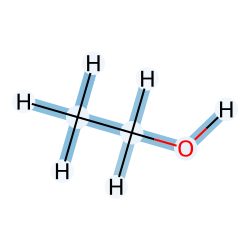

In [25]:
visualize_contributions("CCO", model)

In [26]:
from typing import Optional


def visualize_contributions(
    smi,
    contribs,
    cmap="bwr_r",
    alpha=0.7,
    size=(250, 250),
    legend: Optional[str] = None,
):
    contrib_values = [v for sub_dict in contribs.values() for v in sub_dict.values()]
    cmap = cm.get_cmap(cmap)
    norm = colors.Normalize(vmin=min(contrib_values), vmax=max(contrib_values))

    if "nodes" in contribs:
        atom_colors = {}
        for i, val in contribs["nodes"].items():
            rgba = list(cmap(norm(val)))
            rgba[3] = alpha
            atom_colors[i] = tuple(rgba)

    if "edges" in contribs:
        bond_colors = {}
        for i, val in contribs["edges"].items():
            rgba = list(cmap(norm(val)))
            rgba[3] = alpha
            bond_colors[i] = tuple(rgba)

    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(*size)

    if "nodes" in contribs and "edges" in contribs:
        rdMolDraw2D.PrepareAndDrawMolecule(
            drawer,
            mol,
            highlightAtoms=list(atom_colors.keys()),
            highlightAtomColors=atom_colors,
            highlightBonds=list(bond_colors.keys()),
            highlightBondColors=bond_colors,
            legend=legend,
        )
    elif "nodes" in contribs and "edges" not in contribs:
        rdMolDraw2D.PrepareAndDrawMolecule(
            drawer,
            mol,
            highlightAtoms=list(atom_colors.keys()),
            highlightAtomColors=atom_colors,
            legend=legend,
        )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace("svg:", "")
    return svg

/tmp/ipykernel_27836/1799110379.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


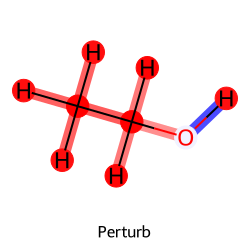

In [27]:
smi = "CCO"

contribs_perturb = calc_contrib_perturb(smi, model, device=device)
svg = visualize_contributions(smi, contribs_perturb, legend="Perturb")
SVG(svg)

/tmp/ipykernel_27836/1799110379.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


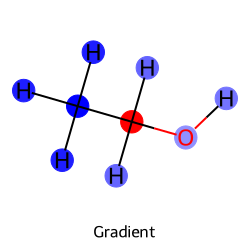

In [28]:
contribs_gradient = calc_contrib_gradient(smi, model, device=device)
svg = visualize_contributions(smi, contribs_gradient, legend="Gradient")
SVG(svg)

/tmp/ipykernel_27836/1799110379.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


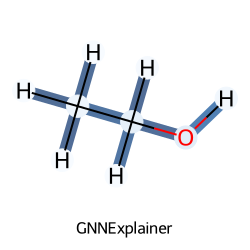

In [29]:
contribs_explainer = calc_contrib_explainer(
    smi, model, device=device, explainer_epochs=200
)
svg = visualize_contributions(
    smi, contribs_explainer, cmap="Blues", legend="GNNExplainer"
)
SVG(svg)